<a href="https://colab.research.google.com/github/sarasubedi/genreClassification/blob/CNN_model/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

# Dataset Visualization

In [ ]:
datapath = "acousticbrainz-mediaeval-discogs-train.tsv"
data = pd.read_csv(datapath, delimiter='\t')

In [62]:
print(data.shape)
data.head()

(904944, 32)


,recordingmbid,releasegroupmbid,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,...,genre21,genre22,genre23,genre24,genre25,genre26,genre27,genre28,genre29,genre30
0,6eafad9e-3e4e-4af7-ad2c-dba94cfedecf,fa7475c1-78a3-31e3-8b27-ca4fef89ba12,electronic,electronic---ambient,electronic---dark ambient,stage & screen,stage & screen---soundtrack,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8eed6eed-24e7-4ac9-98dd-2e20502c1b13,a0394996-0923-324b-a176-cc1a572cb9e4,rock,rock---brit pop,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a05966c4-aaf8-4508-ba23-3193b5067fc0,3447ebd2-34ed-344e-8217-07a431ac398d,electronic,electronic---downtempo,"folk, world, & country","folk, world, & country---african",hip hop,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,173dc6b4-5f76-4ec7-b86c-10f864187435,4f40cf32-2680-3a23-a9d9-d0fd930db257,electronic,electronic---abstract,electronic---idm,electronic---minimal,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1a00a335-fead-46ec-8d4f-06e8341291ea,0f2ccf4d-d242-3c23-a419-ea548af51df3,electronic,electronic---techno,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
y_train = data['genre1']
x_train = data.drop(['genre1'], axis=1)

Text(0.5, 1.0, 'Main Genre')

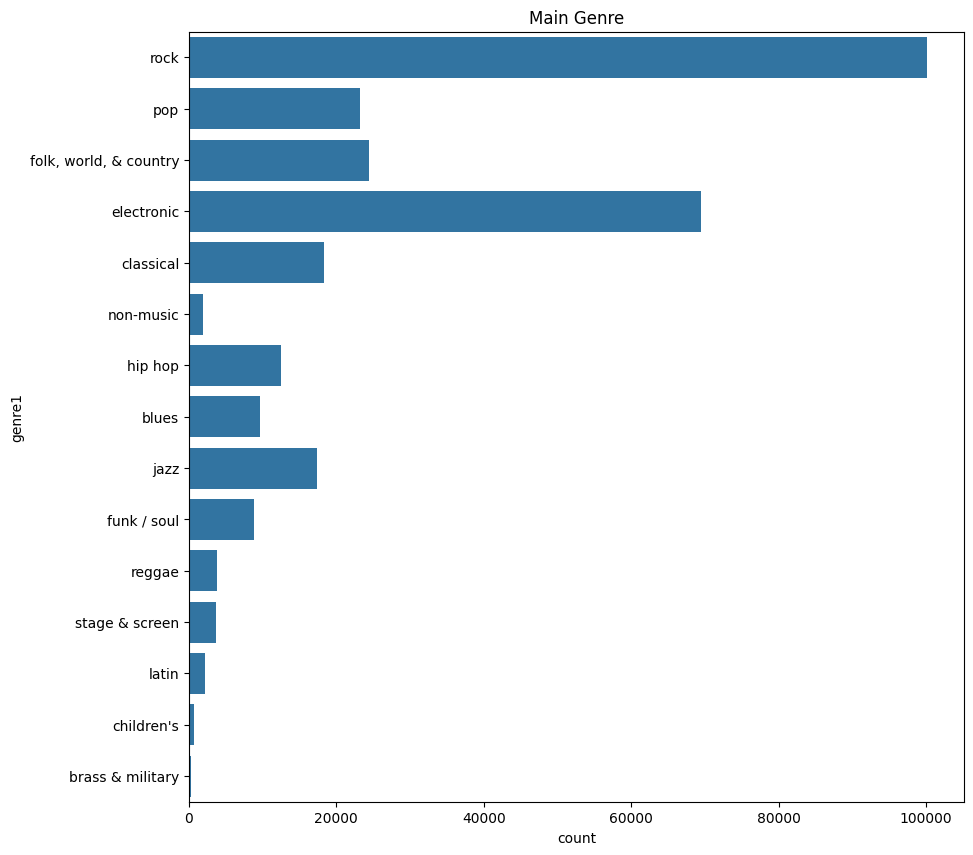

In [95]:
plt.figure(figsize=(10,10))
g = sns.countplot(y_train)
plt.title('Main Genre')

# CNN Model

In [92]:
# model definition
CNN_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128),
    layers.Dense(30)
])

In [93]:
# model compilation
CNN_model.compile(optimizer='adam')

In [94]:
# model summary
CNN_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Data Conversion

In [ ]:
# due to CNN using images, data will need to be in the form of a (mel)spectrogram
# implementation will be determined whether or not the AcousticBrainz preprocessed data can be converted

# CNN Training

In [ ]:
history = CNN_model.fit(x_train,  y_train, epochs=5)

# Model Evaluation

In [ ]:
test_loss, test_acc = CNN_model.evaluate(x_train,  y_train)
print(f'Test accuracy: {test_acc:.2f}')

# Song Prediction

In [ ]:
prediction = CNN_model.predict(np.expand_dims(x_train[0]), axis=0)
prediction = np.argmax(prediction)
print(f'Predicted genre: {prediction}')